In [1]:
import numpy as np
import pandas as pd

import random

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model
from keras.layers import Dropout, Activation

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

2024-04-07 00:31:27.638275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 00:31:27.683156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 00:31:27.684161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 00:31:28.622411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('/users/siru/WKUSDNDDOS/Codes/controller/Sirudata.csv')

In [3]:
# Data Cleaning

# Checking for NULL values
null_values_mask = df.isnull().any()
null_values_count = null_values_mask.sum()
print('Null values in dataset are', null_values_count)
print('=' * 40)

# Checking for DUPLICATE values
# Add your code for checking duplicates here


# Checkng for DUPLICATE values
df.drop_duplicates(keep='first', inplace = True)

# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 

# stored the data into a pickle file so we can load through
# df.to_pickle('df.pkl')

print("Read {} rows.".format(len(df)))

Null values in dataset are 0
Read 4116074 rows.


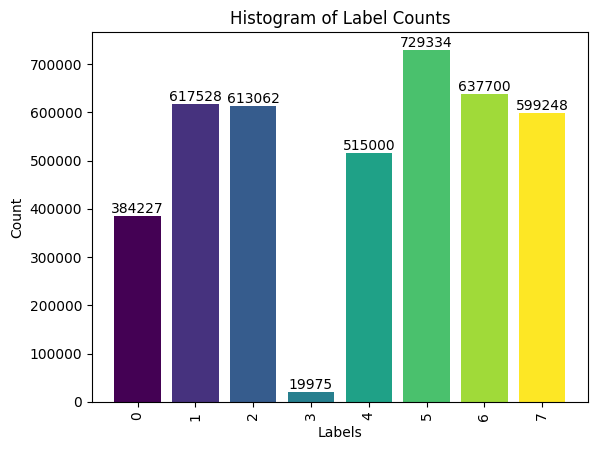

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
label_counts = df.groupby('label').size().reset_index(name='count')

# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(label_counts)))

# Make a histogram
bars = plt.bar(label_counts['label'], label_counts['count'], color=colors)

plt.title('Histogram of Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')

# Rotate the labels vertically
plt.xticks(rotation=90)

# Add counts on top of each bar
for bar, label, count in zip(bars, label_counts['label'], label_counts['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.savefig('After SMOTE.png', dpi=300, bbox_inches='tight')  # Customize filename, DPI, and bounding box

plt.show()


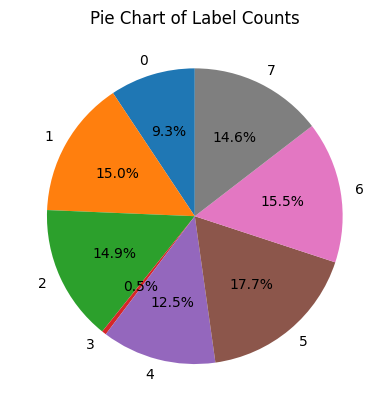

In [34]:
import matplotlib.pyplot as plt

# Your data
label_counts = df.groupby('label').size().reset_index(name='count')

# Make a pie chart
plt.pie(label_counts['count'], labels=label_counts['label'], startangle=90, autopct='%1.1f%%')
plt.title('Pie Chart of Label Counts')

# Save the figure before showing it
plt.savefig('pie_chartAfter SMOTE.png', dpi=300, bbox_inches='tight')  # Customize filename, DPI, and bounding box

# Then display the figure
plt.show()

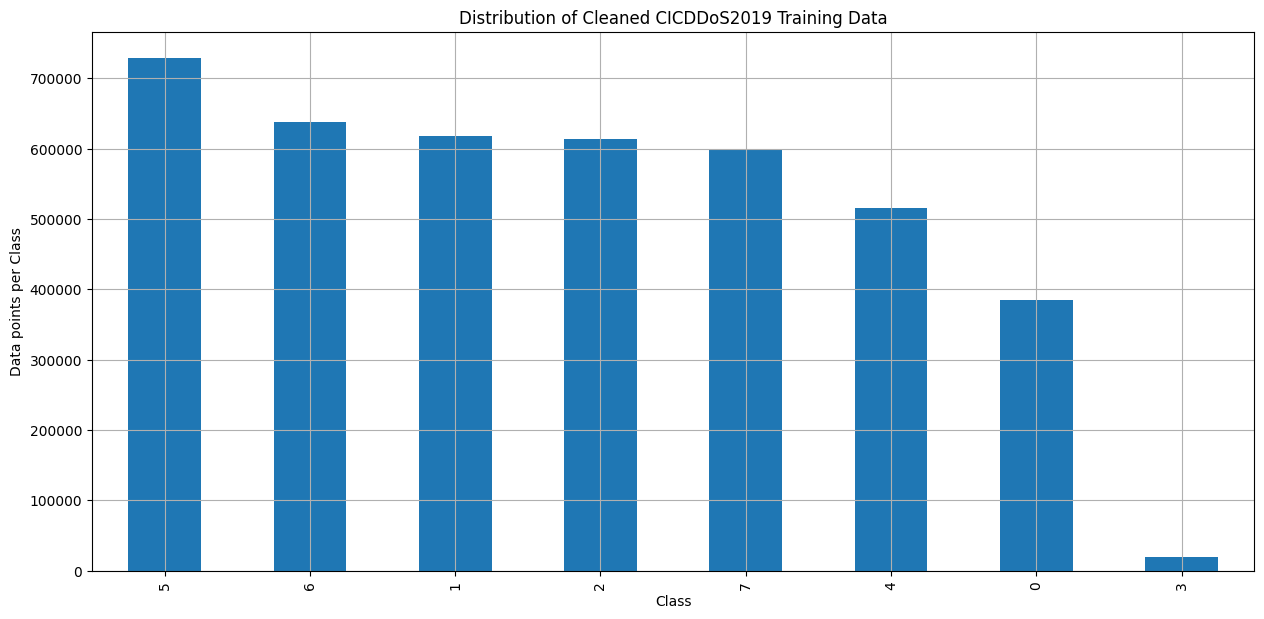

In [10]:
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df['label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CICDDoS2019 Training Data')
plt.grid()
plt.show()

In [11]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class 5 : 729334 ( 17.719 %)
Number of data points in class 6 : 637700 ( 15.493 %)
Number of data points in class 1 : 617528 ( 15.003 %)
Number of data points in class 2 : 613062 ( 14.894 %)
Number of data points in class 7 : 599248 ( 14.559 %)
Number of data points in class 4 : 515000 ( 12.512 %)
Number of data points in class 0 : 384227 ( 9.335 %)
Number of data points in class 3 : 19975 ( 0.485 %)


In [4]:
#drop na values and reset index
data_clean = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['label'] = labelencoder.fit_transform(data_clean['label'])

data_clean['label'].value_counts()

label
5    729334
6    637700
1    617528
2    613062
7    599248
4    515000
0    384227
3     19975
Name: count, dtype: int64

In [15]:
data_clean.columns

Index(['index', 'timestamp', 'datapath_id', 'flow_id', 'ip_src', 'tp_src',
       'ip_dst', 'tp_dst', 'ip_proto', 'icmp_code', 'icmp_type',
       'flow_duration_sec', 'flow_duration_nsec', 'idle_timeout',
       'hard_timeout', 'flags', 'packet_count', 'byte_count',
       'packet_count_per_second', 'packet_count_per_nsecond',
       'byte_count_per_second', 'byte_count_per_nsecond', 'label'],
      dtype='object')

In [5]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
# Assuming the label is in the 23rd column (index 22)
data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]
# Feature matrix X should include columns 1 to 21 (excluding the index and label)
X = data_np[:, 1:22]

# One-hot encoding for the label (assuming label is in the 23rd column)
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(data_np[:, 22].reshape(-1, 1))

# Standard scaling for features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified sampling for data splitting  
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, stratify=Y, shuffle=True
)


# Print dimensions
_features = X.shape[1]
n_classes = Y.shape[1]
print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)


X.shape =  (4116074, 21)
Y.shape =  (4116074, 8)
X_train.shape =  (3087055, 21)
Y_train.shape =  (3087055, 8)
X_test.shape =  (1029019, 21)
Y_test.shape =  (1029019, 8)


Training Class Counts:
0    1    2    3    4    5    6    7  
0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0    547000
                         0.0  1.0  0.0    478275
     1.0  0.0  0.0  0.0  0.0  0.0  0.0    463146
     0.0  1.0  0.0  0.0  0.0  0.0  0.0    459797
          0.0  0.0  0.0  0.0  0.0  1.0    449436
                    1.0  0.0  0.0  0.0    386250
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    288170
0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     14981
Name: count, dtype: int64

Testing Class Counts:
0    1    2    3    4    5    6    7  
0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0    182334
                         0.0  1.0  0.0    159425
     1.0  0.0  0.0  0.0  0.0  0.0  0.0    154382
     0.0  1.0  0.0  0.0  0.0  0.0  0.0    153265
          0.0  0.0  0.0  0.0  0.0  1.0    149812
                    1.0  0.0  0.0  0.0    128750
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     96057
0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      4994
Name: count, dtype: int64


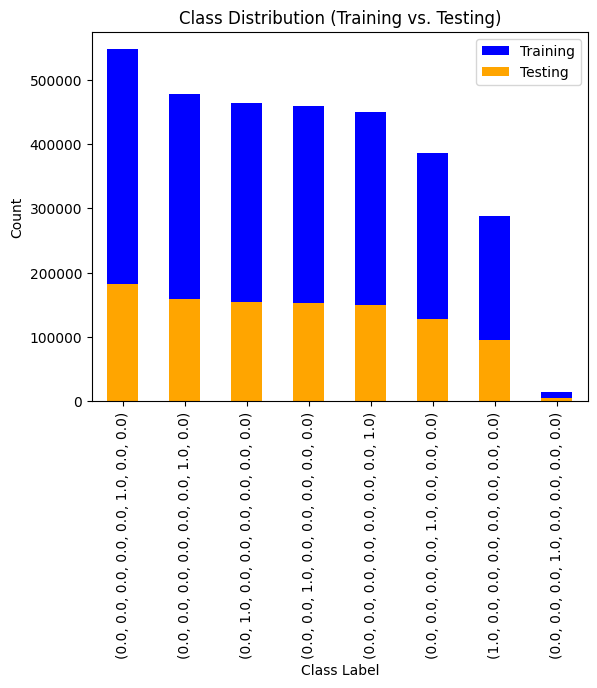

In [35]:
# Assuming you have Y_train and Y_test as NumPy arrays
y_train_df = pd.DataFrame(Y_train)
y_test_df = pd.DataFrame(Y_test)

# Method 1: value_counts()
train_class_counts = y_train_df.value_counts().sort_values(ascending=False)
test_class_counts = y_test_df.value_counts().sort_values(ascending=False)

print("Training Class Counts:")
print(train_class_counts)
print("\nTesting Class Counts:")
print(test_class_counts)

# Method 2: Plotting Class Distribution
train_class_counts.plot(kind="bar", color="blue", label="Training")
test_class_counts.plot(kind="bar", color="orange", label="Testing")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution (Training vs. Testing)")
plt.legend()
plt.show()

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
# Assuming _features and n_classes are defined before this point
# Assuming X_train, Y_train, X_test, Y_test are also defined
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor the validation set loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)
def build_efficient_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(
        filters=hp.Int('conv1d_1_filters', min_value=32, max_value=128, step=16),
        kernel_size=3,
        input_shape=(_features, 1),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_1', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(
        filters=hp.Int('conv1d_2_filters', min_value=32, max_value=128, step=16),
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_2', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(
        filters=hp.Int('conv1d_3_filters', min_value=32, max_value=128, step=16),
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_3', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_dense_1', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(
        units=hp.Int('dense_2_units', min_value=16, max_value=128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_dense_2', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

# Initialize the Bayesian Optimization tuner
tuner = kt.BayesianOptimization(
    build_efficient_model,
    objective='val_accuracy',
    max_trials=20,  # Adjust the number of trials
    directory='my',
    project_name='myp',
    overwrite=False
)

# Start the hyperparameter tuning process
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, Y_train,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop]  # Add early stopping callback here
)
# After training, you can evaluate the model's performance on the test set
test_results = model.evaluate(X_test, Y_test)

Reloading Tuner from my/myp/tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
64                |48                |conv1d_1_filters
0.0001            |0.01              |l2_1
128               |128               |conv1d_2_filters
0.01              |0.01              |l2_2
80                |96                |conv1d_3_filters
0.001             |0.001             |l2_3
128               |256               |dense_1_units
0.01              |0.0001            |l2_dense_1
0.2               |0.4               |dropout_1
80                |80                |dense_2_units
0.001             |0.01              |l2_dense_2
0.4               |0.3               |dropout_2
5.2175e-05        |0.00018661        |learning_rate

Epoch 1/10
96471/96471 [==============================] - 702s 7ms/step - loss: 0.2118 - accuracy: 0.9857 - val_loss: 0.0588 - val_accuracy: 0.9996
Epoch 2/10
96471/96471 [==============================] - 700s 7ms/step - loss: 0.0551 

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
# Assuming _features and n_classes are defined before this point
# Assuming X_train, Y_train, X_test, Y_test are also defined
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor the validation set loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)
def build_efficient_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(
        filters=hp.Int('conv1d_1_filters', min_value=32, max_value=128, step=16),
        kernel_size=3,
        input_shape=(_features, 1),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_1', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(
        filters=hp.Int('conv1d_2_filters', min_value=32, max_value=128, step=16),
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_2', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(
        filters=hp.Int('conv1d_3_filters', min_value=32, max_value=128, step=16),
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_3', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_dense_1', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(
        units=hp.Int('dense_2_units', min_value=16, max_value=128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_dense_2', values=[1e-4, 1e-3, 1e-2]))))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

# Initialize the Bayesian Optimization tuner
tuner = kt.BayesianOptimization(
    build_efficient_model,
    objective='val_accuracy',
    max_trials=20,  # Adjust the number of trials
    directory='my',
    project_name='myp',
    overwrite=False
)

# Start the hyperparameter tuning process
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, Y_train,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop]  # Add early stopping callback here
)
# After training, you can evaluate the model's performance on the test set
test_results = model.evaluate(X_test, Y_test)

Epoch 1/30
24118/24118 [==============================] - 277s 11ms/step - loss: 0.0893 - accuracy: 0.9895 - val_loss: 0.0232 - val_accuracy: 0.9999
Epoch 2/30
24118/24118 [==============================] - 272s 11ms/step - loss: 0.0231 - accuracy: 0.9994 - val_loss: 0.0179 - val_accuracy: 0.9999
Epoch 3/30
24118/24118 [==============================] - 268s 11ms/step - loss: 0.0181 - accuracy: 0.9996 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 4/30
24118/24118 [==============================] - 266s 11ms/step - loss: 0.0156 - accuracy: 0.9997 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 5/30
24118/24118 [==============================] - 265s 11ms/step - loss: 0.0142 - accuracy: 0.9997 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 6/30
24118/24118 [==============================] - 264s 11ms/step - loss: 0.0132 - accuracy: 0.9997 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 7/30
24118/24118 [==============================] - 263s 11ms/step - loss: 0.0125 - accuracy: 0.9997

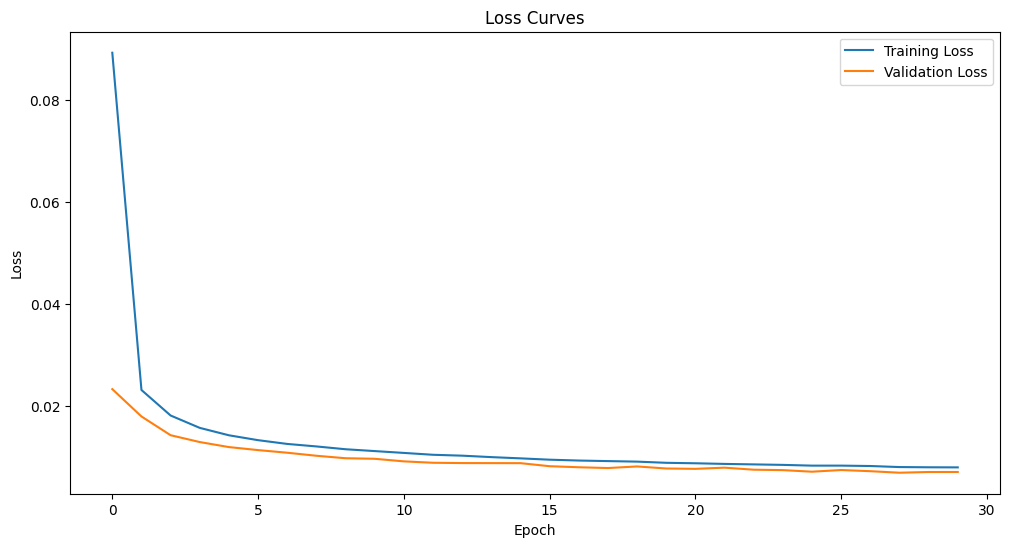

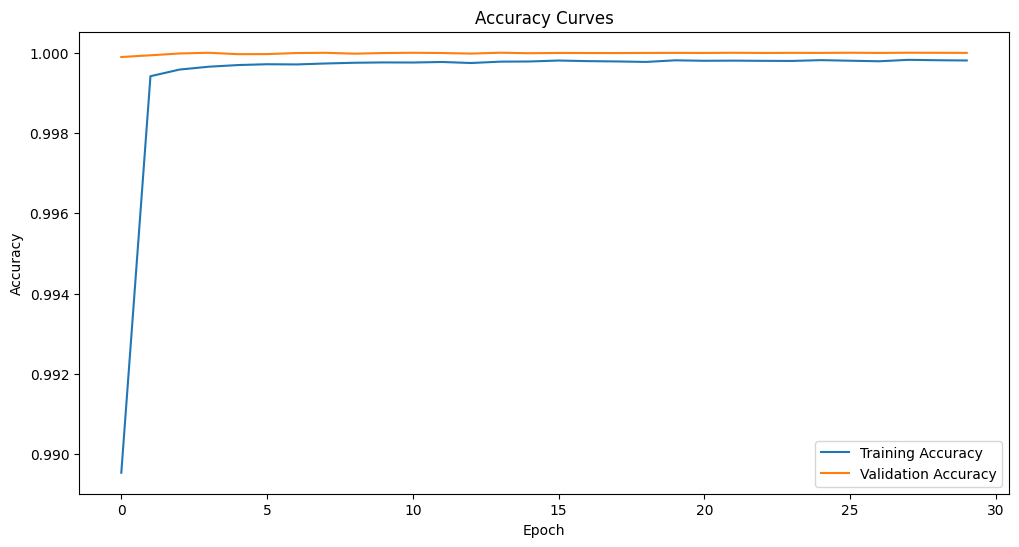

In [21]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers, regularizers

early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor the validation set loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

CNNmodel = keras.Sequential()
CNNmodel.add(layers.Conv1D(
    filters=32,  # Best value for conv1d_1_filters
    kernel_size=3,
    input_shape=(_features, 1),
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)))  # Best value for l2_1
CNNmodel.add(layers.MaxPooling1D(pool_size=2))

CNNmodel.add(layers.Conv1D(
    filters=80,  # Best value for conv1d_2_filters
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)))  # Best value for l2_2
CNNmodel.add(layers.MaxPooling1D(pool_size=2))

CNNmodel.add(layers.Conv1D(
    filters=80,  # Best value for conv1d_3_filters
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)))  # Best value for l2_3
CNNmodel.add(layers.MaxPooling1D(pool_size=2))

CNNmodel.add(layers.Flatten())

CNNmodel.add(layers.Dense(
    units=64,  # Best value for dense_1_units
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)))  # Best value for l2_dense_1
CNNmodel.add(layers.Dropout(0.2))  # Best value for dropout_1

CNNmodel.add(layers.Dense(
    units=64,  # Best value for dense_2_units
    activation='relu',
    kernel_regularizer=regularizers.l2(0.001)))  # Best value for l2_dense_2
CNNmodel.add(layers.Dropout(0.4))  # Best value for dropout_2

CNNmodel.add(layers.Dense(n_classes, activation='softmax'))

CNNmodel.compile(
    optimizer=keras.optimizers.Adam(0.00025224),  # Best value for learning_rate
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Compile the model
history = CNNmodel.fit(X_train, Y_train, epochs=30, batch_size=128, 
                          validation_data=(X_test, Y_test), callbacks=[early_stop])
test_loss, test_accuracy = CNNmodel.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
from tensorflow.keras.models import load_model
CNNmodel.save('wkucnn.keras')

In [17]:
CNNmodell = load_model('wkucnn.h5')

In [24]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagecnn = psutil.cpu_percent(interval=None)
start_processcnn = psutil.Process(os.getpid())
start_memory_usagecnn = start_processcnn.memory_info().rss / (1024 * 1024)  # Convert to MB


# Start prediction timer
start_timecnn = time.time()

# Make predictions
cnnR = CNNmodell.predict(X_test)

# Stop prediction timer
end_timecnn = time.time()

# Measure CPU and RAM usage after prediction
end_cpu_usagecnn = psutil.cpu_percent(interval=None)
end_processcnn = psutil.Process(os.getpid())
end_memory_usagecnn = end_processcnn.memory_info().rss / (1024 * 1024)  # Convert to MB


# Calculate usage differences
cpu_usage_changecnn = end_cpu_usagecnn - start_cpu_usagecnn
memory_usage_changecnn = end_memory_usagecnn - start_memory_usagecnn

# Print results
print(f"Prediction time: {end_timecnn - start_timecnn:.4f} seconds")
print(f"CPU usage change: {cpu_usage_changecnn:.2f} %")
print(f"RAM usage change: {memory_usage_changecnn:.2f} MB")

32157/32157 [==============================] - 62s 2ms/step
Prediction time: 72.7258 seconds
CPU usage change: 4.00 %
RAM usage change: 123.21 MB


Fold 1:
19295/19295 [==============================] - 50s 3ms/step - loss: 0.0070 - accuracy: 1.0000
Fold 2:
19295/19295 [==============================] - 51s 3ms/step - loss: 0.0070 - accuracy: 1.0000
Fold 3:
19295/19295 [==============================] - 51s 3ms/step - loss: 0.0070 - accuracy: 1.0000
Fold 4:
19295/19295 [==============================] - 51s 3ms/step - loss: 0.0070 - accuracy: 1.0000
Fold 5:
19295/19295 [==============================] - 51s 3ms/step - loss: 0.0070 - accuracy: 1.0000

Average Validation Accuracy: 0.9999931931495667


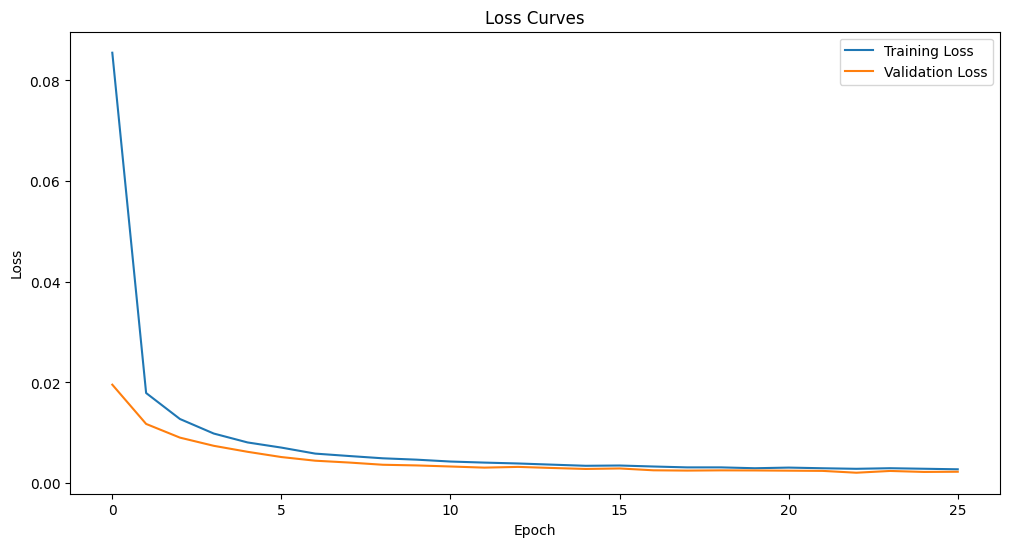

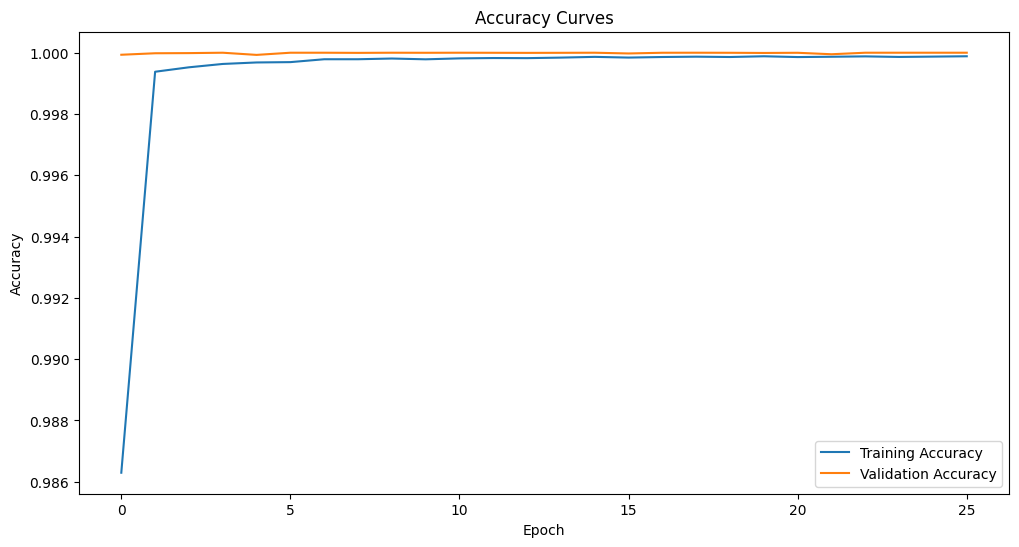

In [32]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

#
cnnfold = load_model('wkucnn.h5')

# Load the pretrained model

# Initialize K-Fold Splitter
k = 5  # Number of folds (you can adjust this)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store evaluation results
fold_accuracies = []

# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}:")

    # Create train and validation sets for this fold
    X_fold_train, Y_fold_train = X_train[train_index], Y_train[train_index]
    X_fold_val, Y_fold_val = X_train[val_index], Y_train[val_index]

    # Evaluate the pretrained model on X_fold_val, Y_fold_val
    _, accuracy = cnnfold.evaluate(X_fold_val, Y_fold_val)
    fold_accuracies.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print("\nAverage Validation Accuracy:", average_accuracy)

# Plot the loss and accuracy curves (optional)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [22]:
LSTMmodell = load_model('wkulstm.h5')

In [26]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usageLSTMmodel = psutil.cpu_percent(interval=None)
start_processLSTMmodel = psutil.Process(os.getpid())
start_memory_usageLSTMmodel = start_processLSTMmodel.memory_info().rss / (1024 * 1024)  # Convert to MB


# Start prediction timer
start_timeLSTMmodel = time.time()

# Make predictions
LSTMmodelR = LSTMmodel.predict(X_test)

# Stop prediction timer
end_timeLSTMmodel = time.time()

# Measure CPU and RAM usage after prediction
end_cpu_usageLSTMmodel = psutil.cpu_percent(interval=None)
end_processLSTMmodel = psutil.Process(os.getpid())
end_memory_usageLSTMmodel = end_processLSTMmodel.memory_info().rss / (1024 * 1024)  # Convert to MB


# Calculate usage differences
cpu_usage_changeLSTMmodel = end_cpu_usageLSTMmodel - start_cpu_usageLSTMmodel
memory_usage_changeLSTMmodel = end_memory_usageLSTMmodel - start_memory_usageLSTMmodel

# Print results
print(f"Prediction time: {end_timeLSTMmodel - start_timeLSTMmodel:.4f} seconds")
print(f"CPU usage change: {cpu_usage_changeLSTMmodel:.2f} %")
print(f"RAM usage change: {memory_usage_changeLSTMmodel:.2f} MB")

32157/32157 [==============================] - 340s 11ms/step
Prediction time: 351.1272 seconds
CPU usage change: 6.00 %
RAM usage change: 37.97 MB


In [29]:
!pip install memory-profiler

Defaulting to user installation because normal site-packages is not writeable


In [71]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model
# Assuming X_test and Y_test are already defined
escore = CNNmodell.evaluate(X_test, Y_test, batch_size=128)
pred = CNNmodell.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)

32157/32157 [==============================] - 68s 2ms/step
Completed
Time taken: 0:01:55.442531
Validation score: 0.9999951410032274
Evaluation score: [0.006967328023165464, 0.9999951124191284]
Recall score: 0.9999951410032274
Precision score: 0.9999951412992295
F1 Measure score: 0.9999951410378902
ROC-AUC score: 1.0
Overall False Positive Rate: 6.930039195556502e-07
Overall False Negative Rate: 4.0483994248034096e-06


In [33]:
# Assuming 'history' contains the training history
# Check if 'loss' and 'accuracy' are present in the history dictionary
if 'loss' in history.history and 'accuracy' in history.history:
    print("Training loss history:", history.history['loss'])
    print("Training accuracy history:", history.history['accuracy'])
else:
    print("Training history not available or incomplete.")


Training loss history: [0.08551318198442459, 0.017891284078359604, 0.012728800997138023, 0.009838556870818138, 0.00806904025375843, 0.007044082507491112, 0.005850761663168669, 0.005373853258788586, 0.004917478654533625, 0.004646375309675932, 0.004274638369679451, 0.00406453013420105, 0.003889192594215274, 0.003657267428934574, 0.003429667791351676, 0.003485011402517557, 0.0032874909229576588, 0.003112298669293523, 0.003114083781838417, 0.002943759085610509, 0.0030714855529367924, 0.0029408156406134367, 0.002830818761140108, 0.0029463600367307663, 0.0028413860127329826, 0.002734160516411066]
Training accuracy history: [0.9862937331199646, 0.9993793368339539, 0.9995241165161133, 0.9996336102485657, 0.9996822476387024, 0.9996932148933411, 0.9997871518135071, 0.9997871518135071, 0.999810516834259, 0.9997848868370056, 0.9998153448104858, 0.9998266696929932, 0.9998231530189514, 0.9998406171798706, 0.9998645782470703, 0.999841570854187, 0.9998600482940674, 0.999870777130127, 0.999860048294067

In [37]:
LSTMmodel.save('wkulstm.h5')

/users/siru/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1:
19295/19295 [==============================] - 213s 11ms/step - loss: 8.6911e-04 - accuracy: 1.0000
Fold 2:
19295/19295 [==============================] - 213s 11ms/step - loss: 8.8247e-04 - accuracy: 1.0000
Fold 3:
19295/19295 [==============================] - 213s 11ms/step - loss: 8.6959e-04 - accuracy: 1.0000
Fold 4:
19295/19295 [==============================] - 214s 11ms/step - loss: 8.7020e-04 - accuracy: 1.0000
Fold 5:
19295/19295 [==============================] - 214s 11ms/step - loss: 8.6893e-04 - accuracy: 1.0000

Average Validation Accuracy: 0.9999993562698364


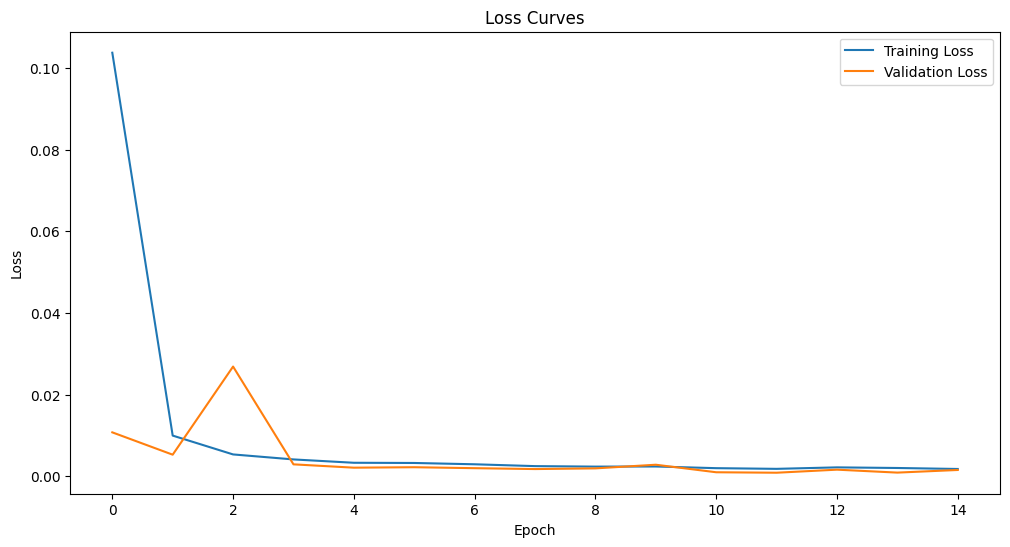

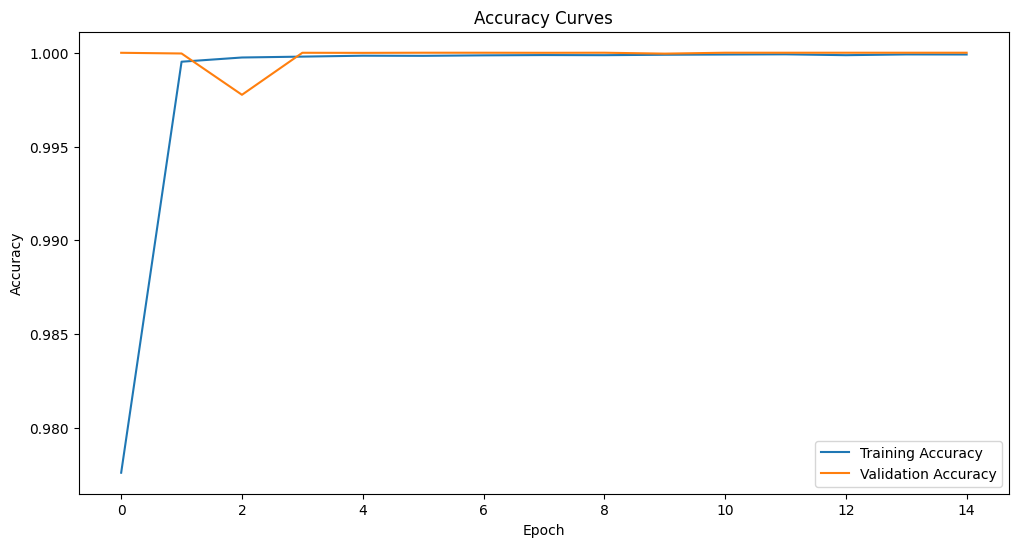

In [38]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

#
lstmfold = load_model('wkulstm.h5')

# Load the pretrained model

# Initialize K-Fold Splitter
k = 5  # Number of folds (you can adjust this)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store evaluation results
fold_accuracies = []

# Iterate over folds
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}:")

    # Create train and validation sets for this fold
    X_fold_train, Y_fold_train = X_train[train_index], Y_train[train_index]
    X_fold_val, Y_fold_val = X_train[val_index], Y_train[val_index]

    # Evaluate the pretrained model on X_fold_val, Y_fold_val
    _, accuracy = lstmfold.evaluate(X_fold_val, Y_fold_val)
    fold_accuracies.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print("\nAverage Validation Accuracy:", average_accuracy)

# Plot the loss and accuracy curves (optional)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
loss_values = history.history['loss']
accuracy_values = history.history['accuracy']

Epoch 1/30
24118/24118 [==============================] - 453s 19ms/step - loss: 0.0840 - accuracy: 0.9880 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 2/30
24118/24118 [==============================] - 447s 19ms/step - loss: 0.0188 - accuracy: 0.9993 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 3/30
24118/24118 [==============================] - 446s 18ms/step - loss: 0.0121 - accuracy: 0.9996 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 4/30
24118/24118 [==============================] - 445s 18ms/step - loss: 0.0094 - accuracy: 0.9996 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 5/30
24118/24118 [==============================] - 443s 18ms/step - loss: 0.0076 - accuracy: 0.9997 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 6/30
24118/24118 [==============================] - 432s 18ms/step - loss: 0.0066 - accuracy: 0.9997 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 7/30
24118/24118 [==============================] - 441s 18ms/step - loss: 0.0058 - accuracy: 0.9997

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



24118/24118 [==============================] - 440s 18ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 10/30
24118/24118 [==============================] - 440s 18ms/step - loss: 0.0046 - accuracy: 0.9998 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 11/30
24118/24118 [==============================] - 436s 18ms/step - loss: 0.0043 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 12/30
24118/24118 [==============================] - 415s 17ms/step - loss: 0.0040 - accuracy: 0.9998 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 13/30
24118/24118 [==============================] - 424s 18ms/step - loss: 0.0040 - accuracy: 0.9998 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 14/30
24118/24118 [==============================] - 419s 17ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 15/30
24118/24118 [==============================] - 433s 18ms/step - loss: 0.0038 - accuracy: 0.9998 - va

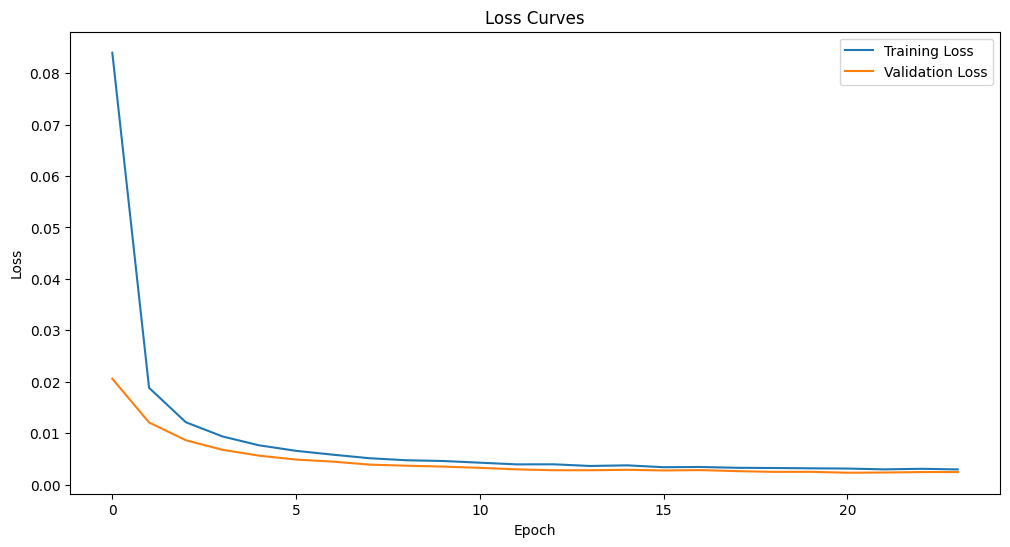

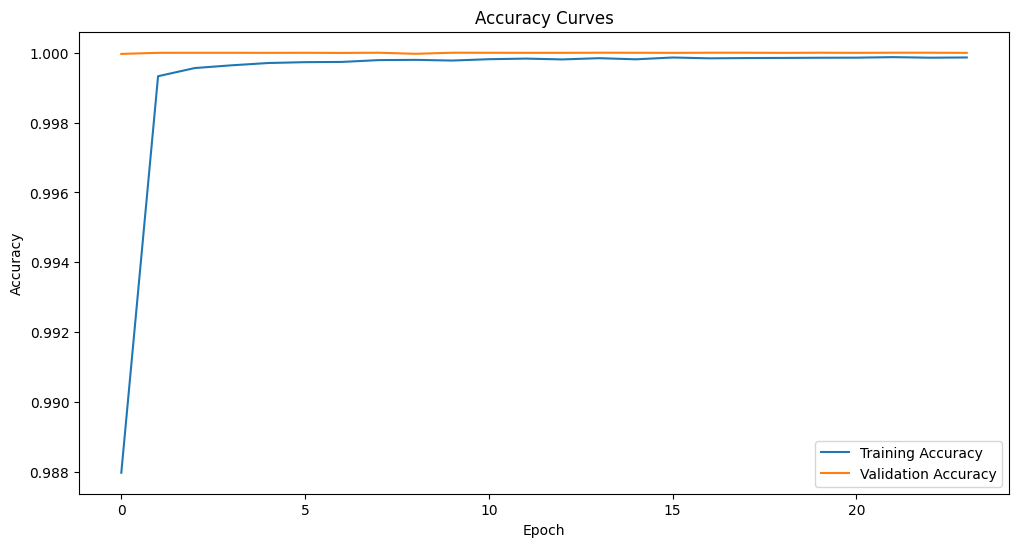

In [40]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

CNNBiLSTMmodel = keras.Sequential()

# Convolutional Layers
CNNBiLSTMmodel.add(layers.Conv1D(
    filters=32,
    kernel_size=3,
    input_shape=(_features, 1),
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)
))
CNNBiLSTMmodel.add(layers.MaxPooling1D(pool_size=2))

CNNBiLSTMmodel.add(layers.Conv1D(
    filters=80,
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)
))
CNNBiLSTMmodel.add(layers.MaxPooling1D(pool_size=2))

# BiLSTM Layer
CNNBiLSTMmodel.add(layers.Bidirectional(layers.LSTM(
    units=64,
    activation='relu',
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.001)
)))
CNNBiLSTMmodel.add(layers.Dropout(0.4))

CNNBiLSTMmodel.add(layers.Flatten())

# Fully Connected Layers
CNNBiLSTMmodel.add(layers.Dense(
    units=64,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)
))
CNNBiLSTMmodel.add(layers.Dropout(0.2))

CNNBiLSTMmodel.add(layers.Dense(
    units=64,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.001)
))
CNNBiLSTMmodel.add(layers.Dropout(0.4))

CNNBiLSTMmodel.add(layers.Dense(n_classes, activation='softmax'))

CNNBiLSTMmodel.compile(
    optimizer=keras.optimizers.Adam(0.00025224),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compile and train the model
history = CNNBiLSTMmodel.fit(X_train, Y_train, epochs=30, batch_size=128, 
                             validation_data=(X_test, Y_test), callbacks=[early_stop])
test_loss, test_accuracy = CNNBiLSTMmodel.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [41]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model
# Assuming X_test and Y_test are already defined
escore = CNNBiLSTMmodel.evaluate(X_test, Y_test, batch_size=128)
pred = CNNBiLSTMmodel.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)

32157/32157 [==============================] - 122s 4ms/step
Completed
Time taken: 0:03:13.427645
Validation score: 0.9999970846019364
Evaluation score: [0.002327084308490157, 0.999997079372406]
Recall score: 0.9999970846019364
Precision score: 0.9999970846590012
F1 Measure score: 0.9999970841782362
ROC-AUC score: 1.0
Overall False Positive Rate: 4.282024404113484e-07
Overall False Negative Rate: 7.50901081297557e-05


2024-04-02 05:20:24.142681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/30
24118/24118 [==============================] - 420s 17ms/step - loss: 0.0919 - accuracy: 0.9846 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 2/30
24118/24118 [==============================] - 412s 17ms/step - loss: 0.0203 - accuracy: 0.9993 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 3/30
24118/24118 [==============================] - 401s 17ms/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 4/30
24118/24118 [==============================] - 409s 17ms/step - loss: 0.0107 - accuracy: 0.9996 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 5/30
24118/24118 [==============================] - 408s 17ms/step - loss: 0.0085 - accuracy: 0.9997 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 6/30
24118/24118 [==============================] - 407s 17ms/step - loss: 0.0072 - accuracy: 0.9997 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 7/30
24118/24118 [==============================] - 402s 17ms/step - loss: 0.0062 - accuracy: 0.9998

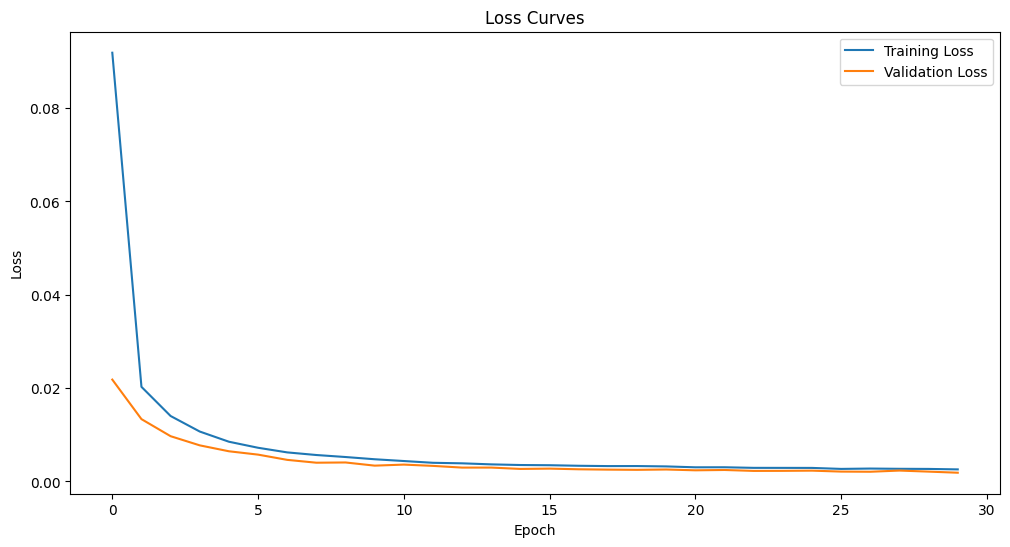

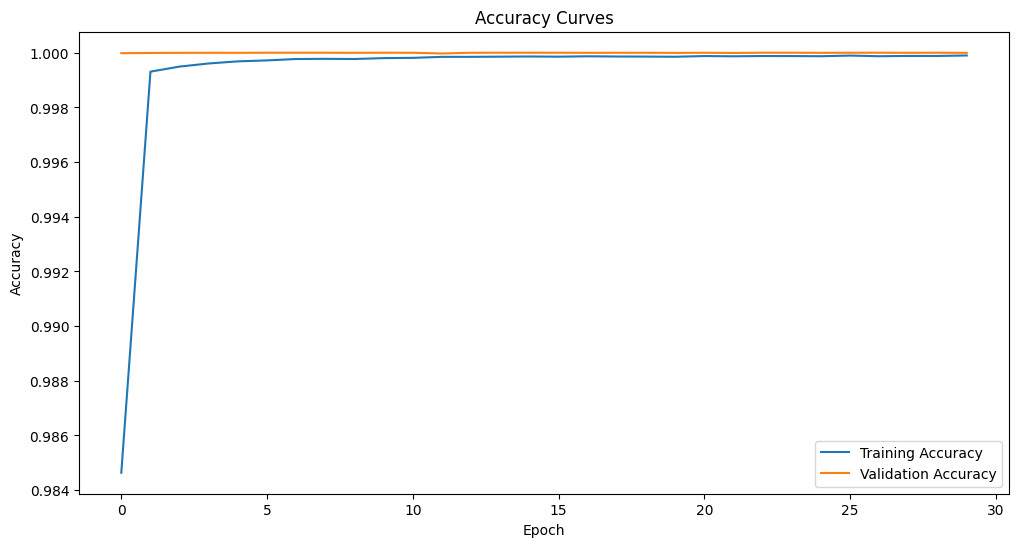

In [7]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

CNNBiLSTMmodel = keras.Sequential()

# Convolutional Layers
CNNBiLSTMmodel.add(layers.Conv1D(
    filters=32,
    kernel_size=3,
    input_shape=(_features, 1),
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)
))
CNNBiLSTMmodel.add(layers.MaxPooling1D(pool_size=2))

CNNBiLSTMmodel.add(layers.Conv1D(
    filters=80,
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)
))
CNNBiLSTMmodel.add(layers.MaxPooling1D(pool_size=2))

# BiLSTM Layer
CNNBiLSTMmodel.add(layers.Bidirectional(layers.LSTM(
    units=64,
    activation='relu',
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.001)
)))
CNNBiLSTMmodel.add(layers.Dropout(0.4))

CNNBiLSTMmodel.add(layers.Flatten())

# Fully Connected Layers
CNNBiLSTMmodel.add(layers.Dense(
    units=64,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)
))
CNNBiLSTMmodel.add(layers.Dropout(0.2))

CNNBiLSTMmodel.add(layers.Dense(
    units=64,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.001)
))
CNNBiLSTMmodel.add(layers.Dropout(0.4))

CNNBiLSTMmodel.add(layers.Dense(n_classes, activation='softmax'))

CNNBiLSTMmodel.compile(
    optimizer=keras.optimizers.Adam(0.00025224),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compile and train the model
history = CNNBiLSTMmodel.fit(X_train, Y_train, epochs=30, batch_size=128, 
                             validation_data=(X_test, Y_test), callbacks=[early_stop])
test_loss, test_accuracy = CNNBiLSTMmodel.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
CNNBiLSTMmodel.save('cnnbilstm.h5')

/users/siru/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
CNNLSTMmodel.save('cnnlstm.h5')

In [64]:
def predict_with_memory_profile(model, data):
    predictions = model.predict(data)
    return predictions
mem_usage_before = memory_profiler.memory_usage()[0]
predictions = predict_with_memory_profile(CNNmodell, X_test)
mem_usage_after = memory_profiler.memory_usage()[0]
increment_prediction = mem_usage_after - mem_usage_before

print("Memory increment for prediction:", increment_prediction)


32157/32157 [==============================] - 64s 2ms/step
Memory increment for prediction: 40.6640625


In [68]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagecnn = psutil.cpu_percent(interval=None)
start_processcnn = psutil.Process(os.getpid())




# Make predictions
cnnR = CNNmodell.predict(X_test)



# Measure CPU and RAM usage after prediction
end_cpu_usagecnn = psutil.cpu_percent(interval=None)
end_processcnn = psutil.Process(os.getpid())



# Calculate usage differences
cpu_usage_changecnn = end_cpu_usagecnn - start_cpu_usagecnn

# Print results
print(f"CPU usage change: {cpu_usage_changecnn:.2f} %")


32157/32157 [==============================] - 66s 2ms/step
CPU usage change: 4.00 %


Epoch 1/30
24118/24118 [==============================] - 395s 16ms/step - loss: 0.1214 - accuracy: 0.9749 - val_loss: 0.0225 - val_accuracy: 0.9999
Epoch 2/30
24118/24118 [==============================] - 387s 16ms/step - loss: 0.0216 - accuracy: 0.9992 - val_loss: 0.0149 - val_accuracy: 0.9999
Epoch 3/30
24118/24118 [==============================] - 385s 16ms/step - loss: 0.0160 - accuracy: 0.9994 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 4/30
24118/24118 [==============================] - 389s 16ms/step - loss: 0.0133 - accuracy: 0.9995 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 5/30
24118/24118 [==============================] - 378s 16ms/step - loss: 0.0116 - accuracy: 0.9995 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 6/30
24118/24118 [==============================] - 384s 16ms/step - loss: 0.0109 - accuracy: 0.9995 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 7/30
24118/24118 [==============================] - 378s 16ms/step - loss: 0.0101 - accuracy: 0.9996

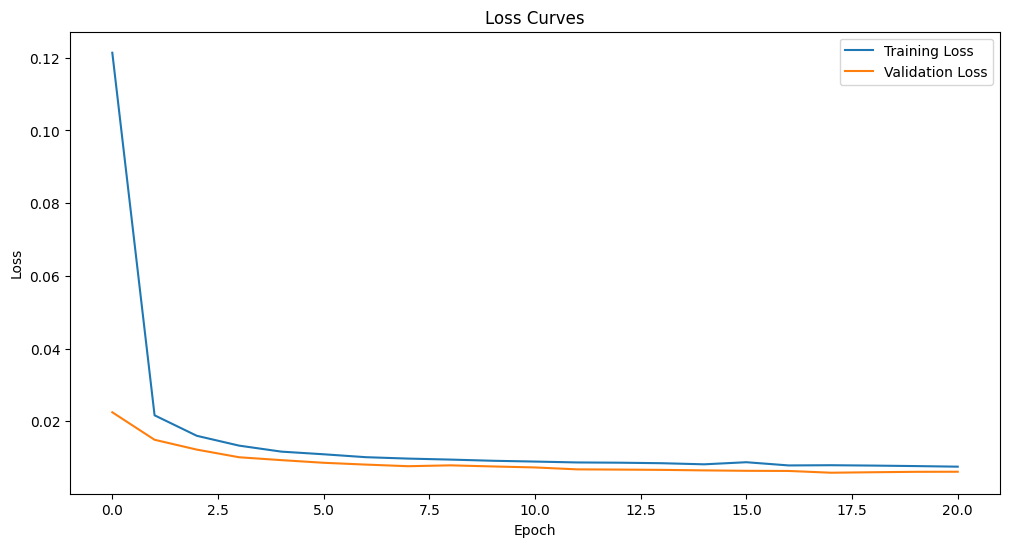

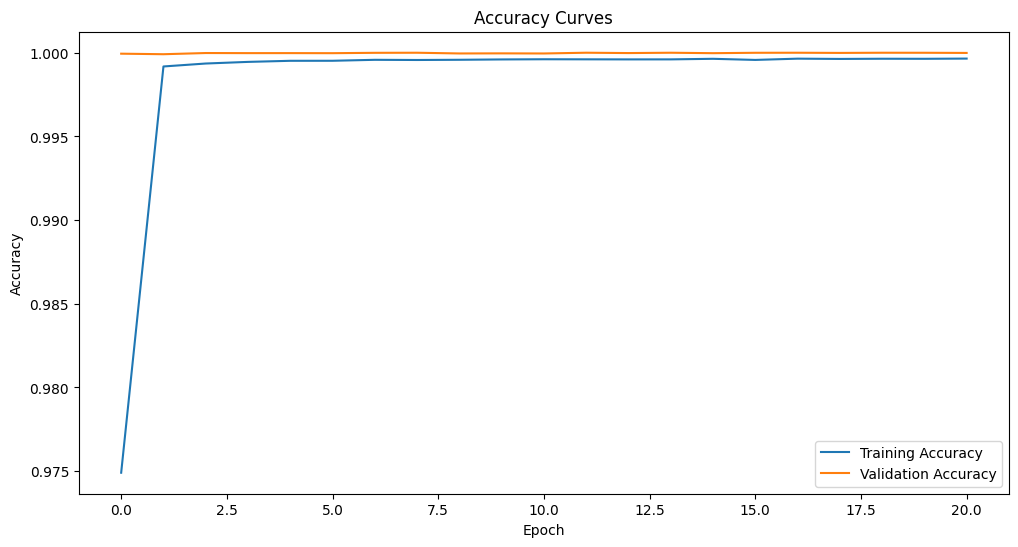

In [56]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Input layer
input_layer = layers.Input(shape=(_features, 1))

# Convolutional Layers
conv1 = layers.Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(input_layer)
maxpool1 = layers.MaxPooling1D(pool_size=2)(conv1)
conv2 = layers.Conv1D(filters=80, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(maxpool1)
maxpool2 = layers.MaxPooling1D(pool_size=2)(conv2)

# BiLSTM Layer
bilstm, forward_h, forward_c, backward_h, backward_c = layers.Bidirectional(layers.LSTM(
    units=64,
    activation='relu',
    return_sequences=True,
    return_state=True,
    kernel_regularizer=regularizers.l2(0.001),
    dropout=0.4,
    recurrent_dropout=0.2,
    recurrent_activation='sigmoid'
))(maxpool2)

# Attention Mechanism
attention = layers.Attention()([forward_h, backward_h])
context_vector = layers.Dot(axes=1)([attention, forward_h])
merged_output = layers.Concatenate(axis=-1)([context_vector, backward_h])

# Fully Connected Layers
dense1 = layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(merged_output)
dropout1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout1)
dropout2 = layers.Dropout(0.4)(dense2)

# Output layer
output_layer = layers.Dense(n_classes, activation='softmax')(dropout2)

# Create the model
CNNBiLSTMAttentionModel = keras.Model(inputs=input_layer, outputs=output_layer)

CNNBiLSTMAttentionModel.compile(
    optimizer=keras.optimizers.Adam(0.00025224),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compile and train the model
history = CNNBiLSTMAttentionModel.fit(X_train, Y_train, epochs=30, batch_size=128, 
                                      validation_data=(X_test, Y_test), callbacks=[early_stop])
test_loss, test_accuracy = CNNBiLSTMAttentionModel.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model
# Assuming X_test and Y_test are already defined
escore = CNNBiLSTMAttentionModel.evaluate(X_test, Y_test, batch_size=128)
pred = CNNBiLSTMAttentionModel.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)

32157/32157 [==============================] - 108s 3ms/step
Completed
Time taken: 0:02:48.961059
Validation score: 0.9999863948090366
Evaluation score: [0.005846729967743158, 0.999988317489624]
Recall score: 0.9999863948090366
Precision score: 0.9999863957121066
F1 Measure score: 0.9999863944759487
ROC-AUC score: 0.9999999990321508
Overall False Positive Rate: 2.01041119799743e-06
Overall False Negative Rate: 6.567580024790798e-05


In [72]:

import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model
# Assuming X_test and Y_test are already defined
escore = CNNBiLSTMmodel.evaluate(X_test, Y_test, batch_size=128)
pred = CNNBiLSTMmodel.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)

32157/32157 [==============================] - 113s 4ms/step
Completed
Time taken: 0:02:59.487760
Validation score: 0.9999961128025818
Evaluation score: [0.0018669451819732785, 0.9999961256980896]
Recall score: 0.9999961128025818
Precision score: 0.9999961159135842
F1 Measure score: 0.9999961135554645
ROC-AUC score: 1.0
Overall False Positive Rate: 4.882693293620762e-07
Overall False Negative Rate: 3.2387195398427277e-06


In [75]:
BiLSTMmodel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 21, 128)           33792     
 onal)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 21, 128)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_25 (Dropout)        (None, 64)               

In [58]:
CNNBiLSTMAttentionModel.save('cnnbilsmatt.h5')

/users/siru/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
def predict_with_memory_profile(model, data):
    predictions = model.predict(data)
    return predictions
mem_usage_before = memory_profiler.memory_usage()[0]
predictions = predict_with_memory_profile(CNNBiLSTMAttentionModel, X_test)
mem_usage_after = memory_profiler.memory_usage()[0]
increment_prediction = mem_usage_after - mem_usage_before

print("Memory increment for prediction:", increment_prediction)


32157/32157 [==============================] - 107s 3ms/step
Memory increment for prediction: 102.39453125


In [69]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagecnn = psutil.cpu_percent(interval=None)
start_processcnn = psutil.Process(os.getpid())




# Make predictions
cnnblatt = CNNBiLSTMAttentionModel.predict(X_test)



# Measure CPU and RAM usage after prediction
end_cpu_usagecnn = psutil.cpu_percent(interval=None)
end_processcnn = psutil.Process(os.getpid())



# Calculate usage differences
cpu_usage_changecnn = end_cpu_usagecnn - start_cpu_usagecnn

# Print results
print(f"CPU usage change: {cpu_usage_changecnn:.2f} %")


32157/32157 [==============================] - 107s 3ms/step
CPU usage change: 9.70 %


In [66]:
def predict_with_memory_profile(model, data):
    predictions = model.predict(data)
    return predictions
mem_usage_before = memory_profiler.memory_usage()[0]
predictions = predict_with_memory_profile(CNNBiLSTMmodel, X_test)
mem_usage_after = memory_profiler.memory_usage()[0]
increment_prediction = mem_usage_after - mem_usage_before

print("Memory increment for prediction:", increment_prediction)


32157/32157 [==============================] - 119s 4ms/step
Memory increment for prediction: 100.98828125


In [70]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagecnn = psutil.cpu_percent(interval=None)
start_processcnn = psutil.Process(os.getpid())




# Make predictions
cnnblatt = CNNBiLSTMmodel.predict(X_test)



# Measure CPU and RAM usage after prediction
end_cpu_usagecnn = psutil.cpu_percent(interval=None)
end_processcnn = psutil.Process(os.getpid())



# Calculate usage differences
cpu_usage_changecnn = end_cpu_usagecnn - start_cpu_usagecnn

# Print results
print(f"CPU usage change: {cpu_usage_changecnn:.2f} %")


32157/32157 [==============================] - 119s 4ms/step
CPU usage change: 6.10 %


In [86]:
import psutil
import time
import numpy as np

# Function to measure CPU and RAM usage and prediction time for one iteration
def measure_performance(model, xtest):
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().used
    start_time = time.time()

    model.predict(xtest)

    cpu_usage = psutil.cpu_percent(interval=None) - cpu_start
    ram_usage = (psutil.virtual_memory().used - ram_start) / (1024 ** 2)  # Convert to MB
    prediction_time = time.time() - start_time

    return {'cpu_usage': cpu_usage, 'ram_usage': ram_usage, 'prediction_time': prediction_time}

# Replace 'your_model' with your actual model object and 'X_test' with your test data
metrics = {'CNN': measure_performance(CNNmodell, X_test)}

# Now you can call your plotting function or print the metrics to check the values
print(metrics)


32157/32157 [==============================] - 69s 2ms/step
{'CNN': {'cpu_usage': 4.1, 'ram_usage': 20.74609375, 'prediction_time': 79.62983059883118}}


32157/32157 [==============================] - 67s 2ms/step


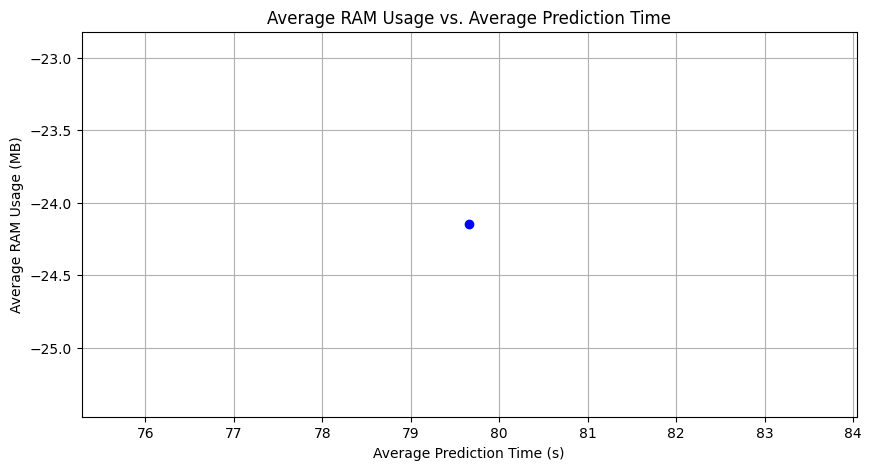

In [93]:
import psutil
import time
import matplotlib.pyplot as plt

# Function to measure RAM usage and prediction time
def measure_performance(model, xtest, iterations=2):
    ram_usages = []
    prediction_times = []

    for _ in range(iterations):
        # Measure RAM usage before prediction
        ram_before = psutil.virtual_memory().used

        # Start the timer
        start_time = time.time()
        
        # Run the model prediction
        model.predict(xtest)

        # Stop the timer
        end_time = time.time()

        # Measure RAM usage after prediction
        ram_after = psutil.virtual_memory().used

        # Calculate the difference in RAM usage and prediction time
        ram_usage = (ram_after - ram_before) / (1024 ** 2)  # Convert to MB
        prediction_time = end_time - start_time

        # Append to lists
        ram_usages.append(ram_usage)
        prediction_times.append(prediction_time)

    # Calculate averages
    avg_ram_usage = sum(ram_usages) / len(ram_usages)
    avg_prediction_time = sum(prediction_times) / len(prediction_times)

    return avg_ram_usage, avg_prediction_time

# Use this function to measure the performance for your model
avg_ram_usage, avg_prediction_time = measure_performance(model, X_test)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.scatter(avg_prediction_time, avg_ram_usage, color='blue')
plt.title('Average RAM Usage vs. Average Prediction Time')
plt.xlabel('Average Prediction Time (s)')
plt.ylabel('Average RAM Usage (MB)')
plt.grid(True)
plt.show()


32157/32157 [==============================] - 68s 2ms/step


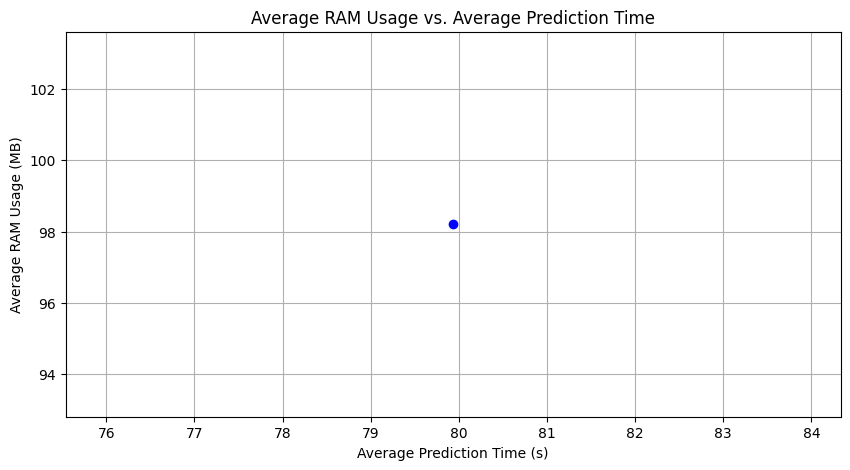

In [95]:
import psutil
import time
import gc
import matplotlib.pyplot as plt

# Function to measure RAM usage and prediction time
def measure_performance(model, xtest, iterations=2):
    ram_usages = []
    prediction_times = []

    for _ in range(iterations):
        gc.collect()  # Attempt to minimize noise by garbage collecting before measurement
        ram_before = psutil.virtual_memory().used
        start_time = time.time()
        model.predict(xtest)
        end_time = time.time()
        ram_after = psutil.virtual_memory().used

        ram_usage = (ram_after - ram_before) / (1024 ** 2)  # Convert to MB
        prediction_time = end_time - start_time

        ram_usages.append(ram_usage)
        prediction_times.append(prediction_time)

    # Calculate averages
    avg_ram_usage = sum(ram_usages) / len(ram_usages)
    avg_prediction_time = sum(prediction_times) / len(prediction_times)

    return avg_ram_usage, avg_prediction_time

# Assuming 'model' is your model instance and 'xtest' is your test data
avg_ram_usage, avg_prediction_time = measure_performance(CNNmodell, X_test)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.scatter(avg_prediction_time, avg_ram_usage, color='blue')
plt.title('Average RAM Usage vs. Average Prediction Time')
plt.xlabel('Average Prediction Time (s)')
plt.ylabel('Average RAM Usage (MB)')
plt.grid(True)
plt.show()


32157/32157 [==============================] - 123s 4ms/step


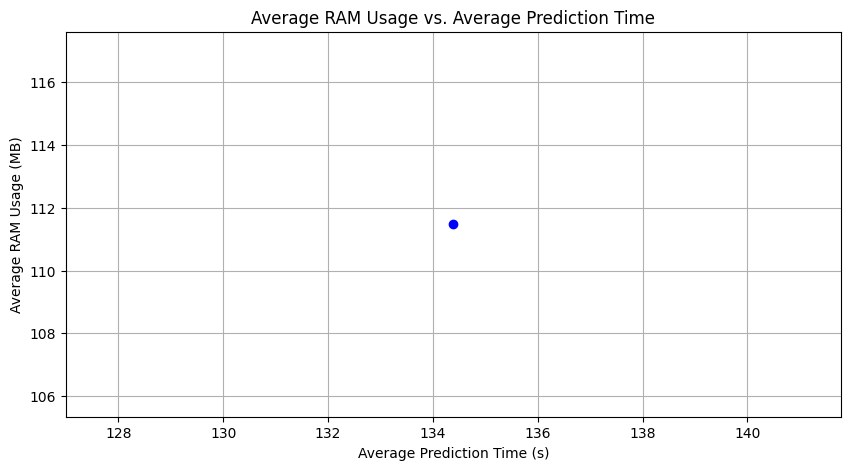

In [96]:
import psutil
import time
import gc
import matplotlib.pyplot as plt

# Function to measure RAM usage and prediction time
def measure_performance(model, xtest, iterations=2):
    ram_usages = []
    prediction_times = []

    for _ in range(iterations):
        gc.collect()  # Attempt to minimize noise by garbage collecting before measurement
        ram_before = psutil.virtual_memory().used
        start_time = time.time()
        model.predict(xtest)
        end_time = time.time()
        ram_after = psutil.virtual_memory().used

        ram_usage = (ram_after - ram_before) / (1024 ** 2)  # Convert to MB
        prediction_time = end_time - start_time

        ram_usages.append(ram_usage)
        prediction_times.append(prediction_time)

    # Calculate averages
    avg_ram_usage = sum(ram_usages) / len(ram_usages)
    avg_prediction_time = sum(prediction_times) / len(prediction_times)

    return avg_ram_usage, avg_prediction_time

# Assuming 'model' is your model instance and 'xtest' is your test data
avg_ram_usage, avg_prediction_time = measure_performance(CNNBiLSTMmodel, X_test)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.scatter(avg_prediction_time, avg_ram_usage, color='blue')
plt.title('Average RAM Usage vs. Average Prediction Time')
plt.xlabel('Average Prediction Time (s)')
plt.ylabel('Average RAM Usage (MB)')
plt.grid(True)
plt.show()


32157/32157 [==============================] - 110s 3ms/step


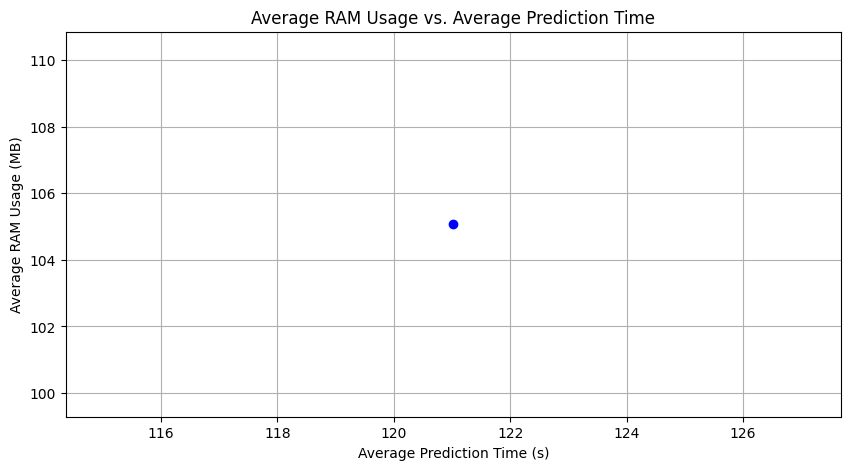

In [97]:
import psutil
import time
import gc
import matplotlib.pyplot as plt

# Function to measure RAM usage and prediction time
def measure_performance(model, xtest, iterations=2):
    ram_usages = []
    prediction_times = []

    for _ in range(iterations):
        gc.collect()  # Attempt to minimize noise by garbage collecting before measurement
        ram_before = psutil.virtual_memory().used
        start_time = time.time()
        model.predict(xtest)
        end_time = time.time()
        ram_after = psutil.virtual_memory().used

        ram_usage = (ram_after - ram_before) / (1024 ** 2)  # Convert to MB
        prediction_time = end_time - start_time

        ram_usages.append(ram_usage)
        prediction_times.append(prediction_time)

    # Calculate averages
    avg_ram_usage = sum(ram_usages) / len(ram_usages)
    avg_prediction_time = sum(prediction_times) / len(prediction_times)

    return avg_ram_usage, avg_prediction_time

# Assuming 'model' is your model instance and 'xtest' is your test data
avg_ram_usage, avg_prediction_time = measure_performance(CNNBiLSTMAttentionModel, X_test)

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.scatter(avg_prediction_time, avg_ram_usage, color='blue')
plt.title('Average RAM Usage vs. Average Prediction Time')
plt.xlabel('Average Prediction Time (s)')
plt.ylabel('Average RAM Usage (MB)')
plt.grid(True)
plt.show()


In [6]:
from tensorflow.keras.models import load_model
CNNBiLSTMAttentionModell=load_model('cnnbilsmatt.h5')
CNNBiLSTMmodell=load_model('cnnbilstm.h5')
CNNmodell = load_model('wkucnn.h5')

2024-04-07 00:36:40.962283: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
